# 在线零售数据

## 简介

> 此数据集包含英国某在线零售商2009年12月到2011年12月的销售数据，该公司主要销售适用于各场合的礼物用品。数据集包括6位数字发票号码（以“C开头的表明此订单取消”）、产品代码、产品描述、发票日期、产品单价、购买数量、客户ID和国家/地区等信息。通过此数据集，我们将探究一些基本问题，如哪些产品的订单取消的比例高？哪些产品比较畅销？销售额与月份是否存在关系？每天中的交易量如何变化？

**1. 数据清洗**

In [6]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [7]:
df1=pd.read_excel('online_retail.xlsx',sheename='Year 2009-2010')
df2=pd.read_excel('online_retail.xlsx',sheetname='Year 2010-2011')
df=pd.concat([df1,df2],ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
Invoice        1067371 non-null object
StockCode      1067371 non-null object
Description    1062989 non-null object
Quantity       1067371 non-null int64
InvoiceDate    1067371 non-null datetime64[ns]
Price          1067371 non-null float64
Customer ID    824364 non-null float64
Country        1067371 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [8]:
df.drop_duplicates(inplace=True)

#提取年、月、日、小时等信息
df['year']=df['InvoiceDate'].dt.year
df['month']=df['InvoiceDate'].dt.month
df['weekday']=df['InvoiceDate'].dt.weekday
df['hour']=df['InvoiceDate'].dt.hour
df['total']=df['Quantity']*df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,year,month,weekday,hour,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,1,7,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,1,7,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,1,7,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,1,7,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,1,7,30.0


**2. 订单取消**

In [9]:
#新增取消订单列
df['cancellation']=df['Invoice'].str.extract('(C)\d+')

C:\Users\Liu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


**2.1 取消订单的比例**

In [10]:
df_c=df.query('cancellation=="C"')
df_c.shape[0]/df.shape[0]

0.01849306316527207

**2.2 哪些产品取消的比例高**

C:\Users\Liu\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:3196: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  old_level.join(right, how=how, return_indexers=True)


([<matplotlib.axis.XTick at 0x1d50501dbe0>,
 <a list of 10 Text xticklabel objects>)

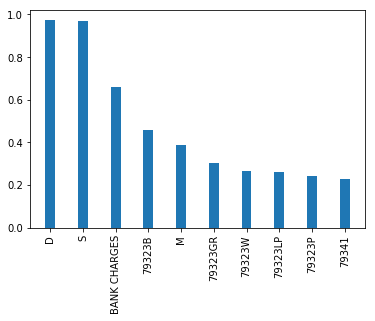

In [79]:
s1=df.groupby(['StockCode','cancellation'])['Invoice'].count()
s2=df.groupby('StockCode')['Invoice'].count()
s2.describe()

#删除销量过低的商品（以100为界）
s3=s2[s2>=100]
proportion=(s1/s3).sort_values(ascending=False)[:10].values

ind=range(len(proportion))
locations=ind
plt.bar(ind,proportion,width=0.3);

labels=['D','S','BANK CHARGES','79323B','M','79323GR','79323W','79323LP','79323P','79341']
plt.xticks(locations,labels,rotation=90)

部分商品取消比例严重偏高，需要对客户进行回访以确定原因，比如是不是因为不包邮导致客户大量取消订单？

**3 销售额**

**3.1 哪些商品销售额高？**

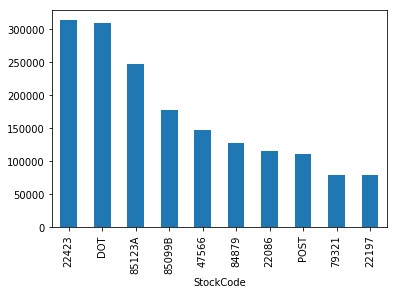

In [12]:
df.groupby('StockCode')['total'].sum().sort_values(ascending=False)[:10].plot(kind='bar')

**3.2 订单总额随月份的变化如何？**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

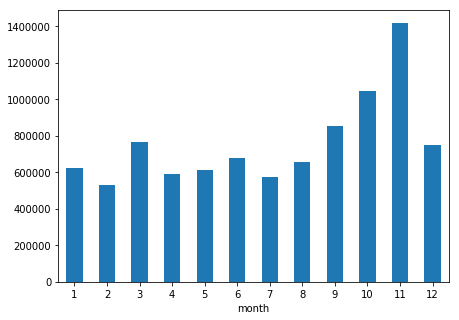

In [13]:
#查询2010年数据并绘图
df_2010=df.query('year==2010')
total=df_2010.groupby('month')['total'].sum()
total.plot(kind='bar',figsize=(7,5))
plt.xticks(rotation=0)

C:\Users\Liu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

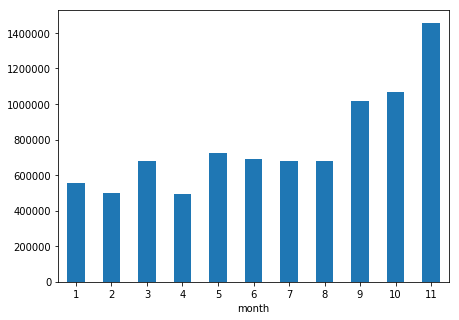

In [14]:
#查询2011年数据并绘图（由于12月数据不全故舍弃）
df_2011=df.query('year==2011')
df_2011.drop(df_2011.query('month==12').index,inplace=True)
total=df_2011.groupby('month')['total'].sum()
total.plot(kind='bar',figsize=(7,5))
plt.xticks(rotation=0)

有2010年和2011年的数据可知，9、10、11三个月份销售额比其他月份高。

**3.3 每天中的什么时候交易最频繁？**

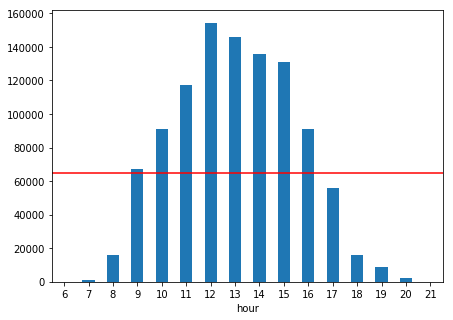

In [15]:
#按小时统计交易量
total_count=df.groupby('hour')['Invoice'].count()
total_count.plot(kind='bar',figsize=(7,5))
plt.xticks(rotation=0)

#计算每小时平均交易量并标注出来
avg=df['Invoice'].count()/df['hour'].unique().size
plt.axhline(avg,color='r')

由此可知，每天10-16时为交易高峰期。

## 总结

> 1.订单整体的取消比例为1.8%，但部分商品订单取消比例远高于此，是否因为支付环节出现新的费用（比如邮费）促使客户取消订单？可通过重新设计产品页面或不将邮费等费用显示在支付环节的方法降低取消比例。

> 2.公司最畅销的三种产品代码为“22423”、“DOT”、“85123A”，每年的九、十、十一公司销售额较高，其它月份可提高优惠力度吸引客户。

> 3.每天10-16时为交易高峰期,在8时之前、18时之后交易量迅速降低，公司的资源，如客服人员等可据此增减。